#  <a name="eda" style="margin-left: 200px;">WaferMap Deffects Classification</a>

<a>
    <div style="margin-left: 0px;">
        <p align="center">
            <img width="18%" align="left" style="margin-right: 10px;" src="./images/wafer-deffect-1.jpg"/>                    <img width="18%" align="left" style="margin-right: 10px; margin-top: 0px;" src="./images/wafer-deffect-3.jpg"/>
            <img width="18%" align="left" style="margin-right: 10px; margin-top: 0px;" src="./images/wafer-deffect-4.png"/>
            <img width="18%" align="left" style="margin-right: 10px; margin-top: 0px;" src="./images/wafer-deffect-5.png"/>
            <img width="18%" align="left" style="margin-right: 10px; margin-top: 0px;" src="./images/wafer-deffect-6.png"/>
        </p>
    </div>
</a>

# Summary

1. [Introduction](#Introduction)<br>
    1.1. [Objective](#Objective)<br>
2. [Exploratory Data Analysis](#eda)<br>
    2.1. [Checking missing values](#missing)<br>
    2.2. [Data cleaning and balancing](#clean)<br>
    2.3. [Visualizing examples](#examples)<br>

3. [Hand-crafted features approach](#hand)<br>
    3.1. [Data transformation](#datatrans)<br>
    &#x200B; 3.1.1. [Density-based Features](#density)<br>
    &#x200B; 3.1.2. [Radon-based Features](#radon)<br>
    &#x200B; 3.1.3. [Geometry-based Features](#geometry)<br>
    3.2. [Classifying with SVM](#svm)<br>
    
4. [A Deep Learning approach](#deep)<br>
    4.1. [Simple CNN](#cnn)<br>
    4.2. [DenseNet + Data augmentation](#densenet)<br>

5. [References](#ref)<br>

# 1. Introduction <a name="Introduction"></a>

Defect detection is an integral part of wafer (chip) fabrication process. It enables defect detection and classification along the process to increase the fab yield (amount of good chips out of total wafers processed). Every detected defect is handled as an indicator of some process malfunction [1]. 
Substrate mapping (or wafer mapping) is a process in which the performance of semiconductor devices on a substrate is represented by a map showing the performance as a colour-coded grid. The map is a convenient representation of the variation in performance across the substrate, since the distribution of those variations may be a clue as to their cause [2].

## 1.1 Objective <a name="Objective"></a>

Given a dataset of Wafer deffects [3], identify different types of wafer map failure patterns automatically, to improve the semi-conductor fabrication process

# 2. Exploratory Data Analysis <a name="eda"></a>

The dataset comes in a 2.1Gb pickle file, that can be read using pandas

In [1]:
import pandas as pd

dataframe = pd.read_pickle("wm811k-wafer-map/LSWMD.pkl")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


* The dataset is composed of 811,457 wafer maps images, and additional info, such as wafer die size, lot name and wafer index.
* The dataset is already split into Training / Test sets, but in this kernel we ignore this info and we re-divided the dataset into training set and test set by hold-out mehtod which will be introduced in later section.

In [2]:
dataframe.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [3]:
dataframe.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


* The dataset was generated from 47,543 lots in a real-world lab. But 47,543 lots * 25 wafer/lot = 1,157,325 wafer maps, and that is larger than 811,457 wafer maps, so something is wrong:


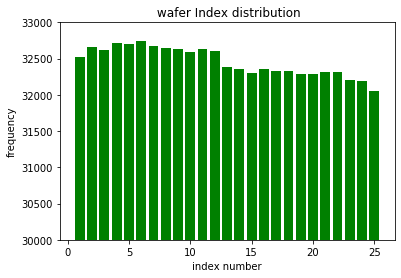

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

unique_index = np.unique(dataframe.waferIndex, return_counts=True)
plt.bar(unique_index[0], unique_index[1], color='green')
plt.title(" wafer Index distribution")
plt.xlabel("index number")
plt.ylabel("frequency")
plt.ylim(30000, 33000)
plt.show()

Not all lots have 25 wafer maps and it may caused by some sensor failure. For this classification task the index number is not needed:

In [5]:
dataframe = dataframe.drop(['waferIndex'], axis=1)

Another item to notice is the Die size, which has different values:

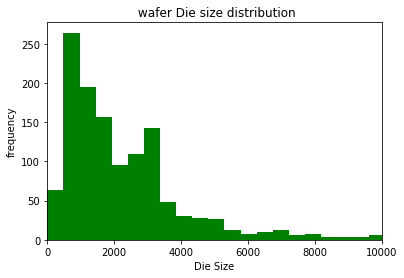

In [6]:
unique_index = np.unique(dataframe.dieSize, return_counts=True)
plt.hist(unique_index[0], bins=100, color='green')
plt.title(" wafer Die size distribution")
plt.xlabel("Die Size")
plt.ylabel("frequency")
plt.xlim(0, 10000)
plt.show()

## 2.1 Checking missing values <a name="missing"></a>

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

dataframe['failureNum'] = dataframe.failureType
dataframe['trainTestNum'] = dataframe.trianTestLabel

mapping_type = {'Center': 0,
                'Donut': 1,
                'Edge-Loc': 2,
                'Edge-Ring': 3,
                'Loc': 4,
                'Random': 5,
                'Scratch': 6,
                'Near-full': 7,
                'none': 8}

mapping_traintest = {'Training': 0,
                     'Test': 1}

dataframe = dataframe.replace({'failureNum': mapping_type,
                               'trainTestNum': mapping_traintest})

Total number of wafers

In [8]:
total_wafers = dataframe.shape[0]
total_wafers

811457

In [9]:
dataframe_with_label = dataframe[(dataframe['failureNum'] >= 0) & (
    dataframe['failureNum'] <= 8)].reset_index()
dataframe_with_pattern = dataframe[(dataframe['failureNum'] >= 0) & (
    dataframe['failureNum'] <= 7)].reset_index()
dataframe_non_pattern = dataframe[(dataframe['failureNum'] == 8)]

In [10]:
print('elements with label = ', dataframe_with_label.shape[0])
print('elements with pattern = ', dataframe_with_pattern.shape[0])
print('elements without pattern (elements with label - elements with pattern) = ',
      dataframe_non_pattern.shape[0])

elements with label =  172950
elements with pattern =  25519
elements without pattern (elements with label - elements with pattern) =  147431


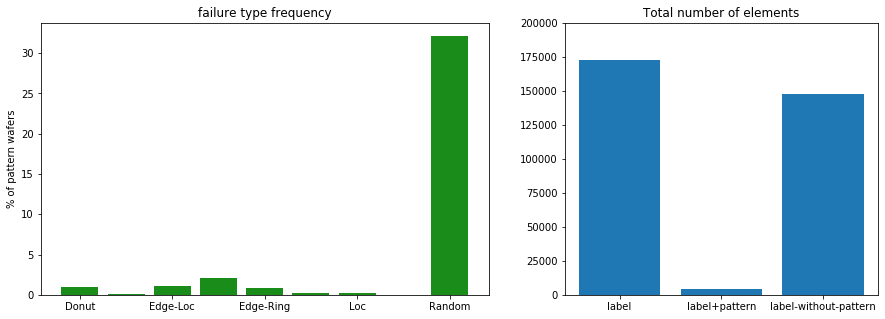

In [77]:
from matplotlib import gridspec

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1.4])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

unique_pattern = np.unique(dataframe_with_label.failureNum,
                           return_counts=True)

labels = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring',
          'Loc', 'Random', 'Scratch', 'Near-full', 'none']

ax1.bar(unique_pattern[0], unique_pattern[1] / dataframe_with_pattern.shape[0],
        color='green', align='center', alpha=0.9)
ax1.set_title("failure type frequency")
ax1.set_ylabel("% of pattern wafers")
ax1.set_xticklabels(labels)

# Number of elements with no labels, elements with patterns,
# and elements without pattern
number_wafers = [dataframe_with_label.shape[0],
                 dataframe_with_pattern.shape[0],
                 dataframe_non_pattern.shape[0]]

labels = ['label', 'label+pattern', 'label-without-pattern']
ax2.bar(labels, number_wafers)
ax2.set_ylim(0, 200000)
ax2.set_title("Total number of elements")
plt.show()

The label+patter quantity is 25519, which represents only 3.1% of the total wafers, and is the amount of examples to be used in the rest of the notebook

## 2.2 Data cleaning and balancing <a name="clean"></a>

Creating a column with the image waferMap shape (width, height)

In [12]:
def find_waferMap_dimensions(waferMap):
    width = np.size(waferMap, axis=0)
    height = np.size(waferMap, axis=1)
    return width, height


dataframe_with_label['waferMapDimension'] = dataframe_with_label.waferMap.apply(find_waferMap_dimensions)
dataframe_with_label.head()

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDimension
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)"


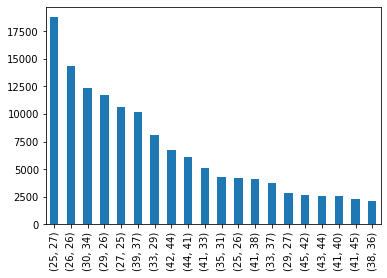

In [13]:
dataframe_with_label['waferMapDimension'].value_counts().head(20).plot.bar();

In [14]:
import cv2

IMAGE_SIZE = (32, 32)


def resize_waferMap(image):
    # Resize image to target size
    return cv2.resize(image.copy(), IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

In [15]:
dataframe_with_label['waferMapResized'] = dataframe_with_label.waferMap.apply(resize_waferMap)
dataframe_with_label['waferMapResizedDimension'] = dataframe_with_label.waferMapResized.apply(find_waferMap_dimensions)
dataframe_with_label.head()

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDimension,waferMapResized,waferMapResizedDimension
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...","(32, 32)"
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","(32, 32)"
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","(32, 32)"
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...","(32, 32)"
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","(32, 32)"


In [16]:
dataframe_with_label = dataframe_with_label.drop(
    ['waferMap', 'dieSize', 'lotName',
     'trianTestLabel', 'trainTestNum',
     'waferMapDimension', 'index',
     'waferMapResizedDimension'], axis=1)

From the 25519 remaining elements, let's take a look at the classes distribution

In [17]:
unique_pattern = np.unique(dataframe_with_label.failureNum,
                           return_counts=True)
print(unique_pattern)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=object), array([  4294,    555,   5189,   9680,   3593,    866,   1193,    149,
       147431]))


Downsampling the rest of the classes to 555:

In [18]:
center = dataframe_with_label[dataframe_with_label['failureNum'] == 0]
donut = dataframe_with_label[dataframe_with_label['failureNum'] == 1]
edge_loc = dataframe_with_label[dataframe_with_label['failureNum'] == 2]
edge_ring = dataframe_with_label[dataframe_with_label['failureNum'] == 3]
loc = dataframe_with_label[dataframe_with_label['failureNum'] == 4]
random = dataframe_with_label[dataframe_with_label['failureNum'] == 5]
scratch = dataframe_with_label[dataframe_with_label['failureNum'] == 6]
near_full = dataframe_with_label[dataframe_with_label['failureNum'] == 7]
none = dataframe_with_label[dataframe_with_label['failureNum'] == 8]

In [19]:
from sklearn.utils import resample


def downsample_class(_class):
    _class = resample(_class, replace=False,
                      n_samples=555, random_state=42)
    return _class

In [20]:
center_downsampled = downsample_class(center)
edge_loc_downsampled = downsample_class(edge_loc)
edge_ring_downsampled = downsample_class(edge_ring)
loc_downsampled = downsample_class(loc)
random_downsampled = downsample_class(random)
scratch_downsampled = downsample_class(scratch)
none_downsampled = downsample_class(none)

In [78]:
downsampled_dataframe = pd.concat([center_downsampled, donut, edge_loc_downsampled, edge_ring_downsampled,
                                   loc_downsampled, random_downsampled, scratch_downsampled, near_full,
                                   none_downsampled])

print('Distribution after downsampling:')
print(downsampled_dataframe['failureNum'].value_counts())

Distribution after downsampling:
8    555
6    555
5    555
4    555
3    555
2    555
1    555
0    555
7    149
Name: failureNum, dtype: int64


In [22]:
dataframe_with_pattern = downsampled_dataframe.copy()

## 2.3 Visualizing examples <a name="examples"></a>

In [23]:
dataframe_with_pattern.head()

,failureType,failureNum,waferMapResized
50263,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,..."
27341,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
127669,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,..."
125300,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,..."
89192,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,..."


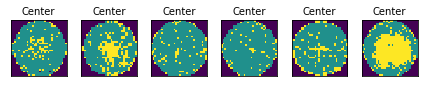

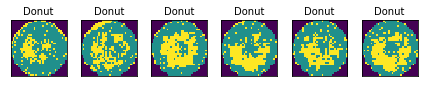

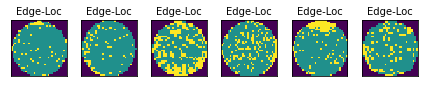

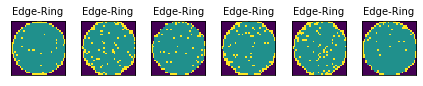

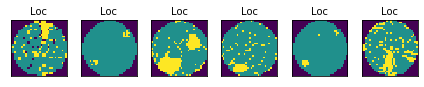

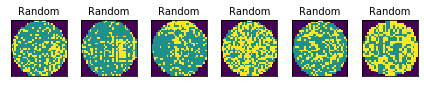

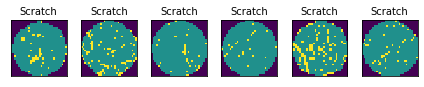

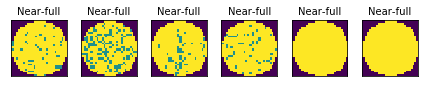

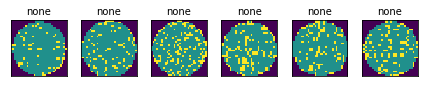

In [25]:
labels = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring',
          'Loc', 'Random', 'Scratch', 'Near-full', 'none']
n_cols = 6

for idx_label, _ in enumerate(labels):
    fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize=(6, 4))
    ax = ax.ravel(order='C')
    # Select an image indexing the category using labels list
    img = dataframe_with_pattern.waferMapResized[dataframe_with_pattern.failureType ==
                                                 labels[idx_label]]
    for idx_col in range(n_cols):
        ax[idx_col].imshow(img[img.index[idx_col]])
        ax[idx_col].set_title(
            dataframe_with_pattern.failureType[img.index[idx_col]][0][0], fontsize=10)
        ax[idx_col].set_xticks([])
        ax[idx_col].set_yticks([])
    plt.tight_layout()
    plt.show()

# 3. Hand-crafted features approach <a name="hand"></a>

Before going for a deep learning approach, a traditional hand-crafted feature method can be tried

## 3.1 Data transformation <a name="datatrans"></a>

### 3.1.1 Density-based Features <a name="density"></a>

The wafer map can be divided into 13 parts, as show in figure below:

<a>
    <div style="margin: 10px;">
        <p align="center">
            <img width="20%" align="left" style="margin-right: 10px;" src="./images/13-regions.png"/>         
        </p>
    </div>
</a>

In [26]:
def calculate_density(wafer_map):
    return 100*(np.sum(wafer_map == 2)/np.size(wafer_map))


def find_regions(wafer_map):
    rows = np.size(wafer_map, axis=0)
    cols = np.size(wafer_map, axis=1)
    internal_division_1 = np.arange(0, rows, rows//5)
    internal_division_2 = np.arange(0, cols, cols//5)

    region1 = wafer_map[internal_division_1[0]: internal_division_1[1], :]
    region2 = wafer_map[:, internal_division_2[4]:]
    region3 = wafer_map[internal_division_1[4]:, :]
    region4 = wafer_map[:, internal_division_2[0]: internal_division_2[1]]
    region5 = wafer_map[internal_division_1[1]: internal_division_1[2],
                internal_division_2[1]: internal_division_2[2]]
    region6 = wafer_map[internal_division_1[1]: internal_division_1[2],
                internal_division_2[2]: internal_division_2[3]]
    region7 = wafer_map[internal_division_1[1]: internal_division_1[2],
                internal_division_2[3]: internal_division_2[4]]
    region8 = wafer_map[internal_division_1[2]: internal_division_1[3],
                internal_division_2[1]: internal_division_2[2]]
    region9 = wafer_map[internal_division_1[2]: internal_division_1[3],
                internal_division_2[2]: internal_division_2[3]]
    region10 = wafer_map[internal_division_1[2]: internal_division_1[3],
                 internal_division_2[3]: internal_division_2[4]]
    region11 = wafer_map[internal_division_1[3]: internal_division_1[4],
                 internal_division_2[1]: internal_division_2[2]]
    region12 = wafer_map[internal_division_1[3]: internal_division_1[4],
                 internal_division_2[2]: internal_division_2[3]]
    region13 = wafer_map[internal_division_1[3]: internal_division_1[4],
                 internal_division_2[3]: internal_division_2[4]]

    feature_region_density = [calculate_density(region1), calculate_density(region2),
                              calculate_density(region3), calculate_density(region4),
                              calculate_density(region5), calculate_density(region6),
                              calculate_density(region7), calculate_density(region8),
                              calculate_density(region9), calculate_density(region10),
                              calculate_density(region11), calculate_density(region12),
                              calculate_density(region3)]

    return feature_region_density

In [27]:
# Using the feature map image column (waferMap), apply find_regions functions to calculate each region density
dataframe_with_pattern['feature_region_density'] = dataframe_with_pattern.waferMapResized.apply(
    find_regions)

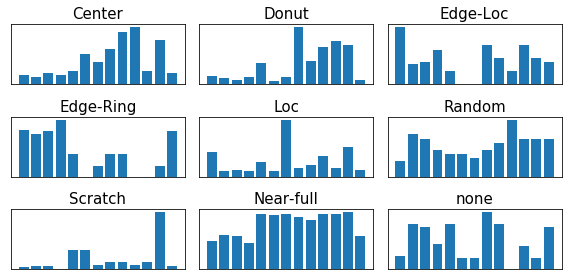

In [28]:
images_each_category = []
for idx, label in enumerate(labels):
    images_each_category.append(dataframe_with_pattern.waferMapResized[
        dataframe_with_pattern.failureType == labels[idx]].index[0])

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 4))
ax = ax.ravel(order='C')
for i in range(9):
    ax[i].bar(np.linspace(1, 13, 13),
              dataframe_with_pattern.feature_region_density[images_each_category[i]])
    ax[i].set_title(dataframe_with_pattern.failureType[images_each_category[i]]
                    [0][0], fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

### 3.1.2 Radon-based Features <a name="radon"></a>

Radon-based features are based on the radon transform, which can generate a 2d representation of the wafer map according to a series of projections.

In [29]:
def change_val(img):
    # Changes white pixels in wafermap to black
    img[img==1] = 0
    return img

dataframe_with_pattern_copy = dataframe_with_pattern.copy()
dataframe_with_pattern_copy['new_waferMap'] = dataframe_with_pattern_copy.waferMapResized.apply(change_val)

/home/igor/anaconda3/lib/python3.7/site-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


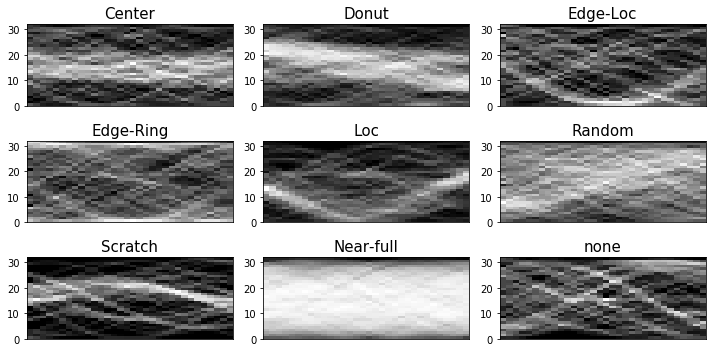

In [30]:
from skimage.transform import radon

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 5))
ax = ax.ravel(order='C')
for i in range(9):
    img = dataframe_with_pattern_copy.new_waferMap[images_each_category[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta, preserve_range=False)

    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(
        0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(
        dataframe_with_pattern_copy.failureType[images_each_category[i]][0][0], fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show()

the wafer still varies in size. so using cubic interpolation to obtain fixed dimension feature values for row mean and row standard deviation from radon transform, for each one the dimension is fixed to 20.

In total, 40 dimensions were extracted for radon-based features.

In [31]:
def cubic_interpolation_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    mean_row = np.mean(sinogram, axis=1)
    x = np.linspace(1, mean_row.size, mean_row.size)
    y = mean_row
    func = interpolate.interp1d(x, y, kind='cubic')
    xnew = np.linspace(1, mean_row.size, 20)
    # Interpolation function returned by interp1d
    ynew = func(xnew)/100
    return ynew


def cubic_interporlation_standard(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    std_row = np.std(sinogram, axis=1)
    x = np.linspace(1, std_row.size, std_row.size)
    y = std_row
    func = interpolate.interp1d(x, y, kind='cubic')
    xnew = np.linspace(1, std_row.size, 20)
    # Interpolation function returned by interp1d
    ynew = func(xnew)/100
    return ynew

In [32]:
from scipy import interpolate

dataframe_with_pattern_copy['feature_cubic_mean'] = dataframe_with_pattern_copy.waferMapResized.apply(
    cubic_interpolation_mean)
dataframe_with_pattern_copy['feature_cubic_standard'] = dataframe_with_pattern_copy.waferMapResized.apply(
    cubic_interporlation_standard)

/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Image dtype is not float. By default radon will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.18 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Image dtype is not float. By default radon will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.18 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  app.launch_new_instance()


**Radon-based feature (interpolate from row mean)**

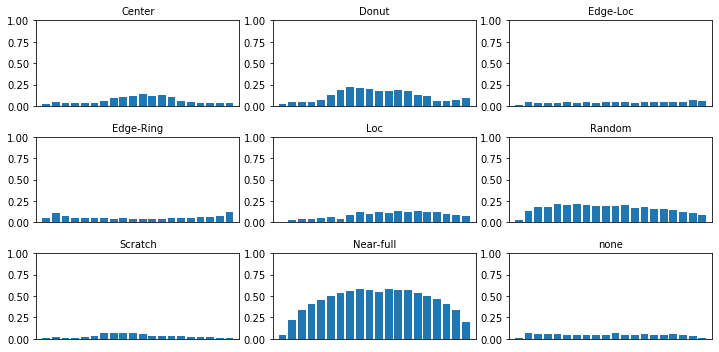

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 5))
ax = ax.ravel(order='C')
for i in range(9):
    ax[i].bar(np.linspace(1, 20, 20),
              dataframe_with_pattern_copy.feature_cubic_mean[images_each_category[i]])
    ax[i].set_title(
        dataframe_with_pattern_copy.failureType[images_each_category[i]][0][0], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0, 21])
    ax[i].set_ylim([0, 1])
plt.tight_layout()
plt.show()

**Radon-based feature (interpolate from row standard deviation)**

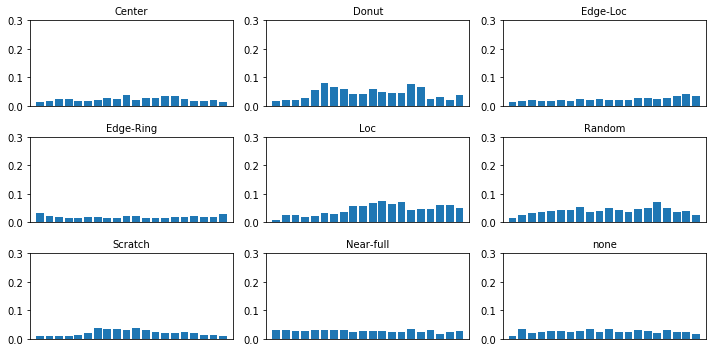

In [34]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 5))
ax = ax.ravel(order='C')
for i in range(9):
    ax[i].bar(np.linspace(1, 20, 20),
              dataframe_with_pattern_copy.feature_cubic_standard[images_each_category[i]])
    ax[i].set_title(
        dataframe_with_pattern_copy.failureType[images_each_category[i]][0][0], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0, 21])
    ax[i].set_ylim([0, 0.3])
plt.tight_layout()
plt.show()

### 3.1.3 Geometry-based Features <a name="geometry"></a>

- Most salient region identifying can be regarded as noise filtering. 
- region-labeling algorithm: choose the max area region as the most salient one.
- extract geometry features like area, perimeter, length of major axes, length of minor axes, solidity and eccentricity


In [35]:
dataframe_with_pattern_copy.head()

,failureType,failureNum,waferMapResized,feature_region_density,new_waferMap,feature_cubic_mean,feature_cubic_standard
50263,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...","[6.25, 4.6875, 7.421875, 6.25, 8.3333333333333...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...","[0.02137445714431452, 0.05126446703876009, 0.0...","[0.014103004723081503, 0.0185076438656294, 0.0..."
27341,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[9.375, 22.265625, 19.140625, 8.85416666666666...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.020703542324475004, 0.07674519325756622, 0....","[0.021702205585179456, 0.0316464573772027, 0.0..."
127669,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...","[5.729166666666666, 9.765625, 5.46875, 9.375, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...","[0.031020597998597754, 0.04601716817895183, 0....","[0.02364379855790732, 0.02463963889991041, 0.0..."
125300,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[6.25, 8.203125, 6.25, 6.770833333333333, 5.55...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.022465382224156026, 0.04941958408990988, 0....","[0.013923326468759713, 0.02428814120205006, 0...."
89192,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...","[9.895833333333332, 12.5, 15.234375, 14.583333...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...","[0.05652095838198795, 0.11109742564594408, 0.0...","[0.03859267924710364, 0.030838372212056583, 0...."


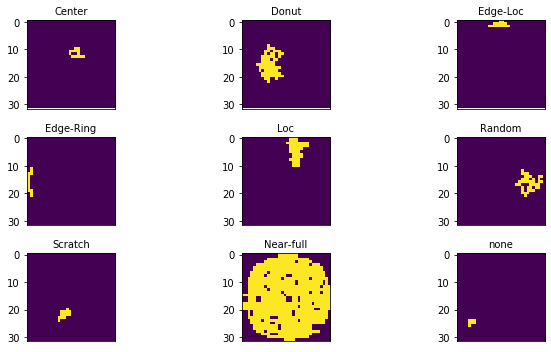

In [36]:
import scipy
import skimage

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 5))
ax = ax.ravel(order='C')
for i in range(9):
    img = dataframe_with_pattern_copy.waferMapResized[images_each_category[i]]
    zero_img = np.zeros(img.shape)
    img_labels = skimage.measure.label(
        img, connectivity=1, background=0)
    img_labels = img_labels-1
    if img_labels.max() == 0:
        no_region = 0
    else:
        info_region = scipy.stats.mode(img_labels[img_labels > -1], axis=None)
        no_region = info_region[0]

    zero_img[np.where(img_labels == no_region)] = 2
    ax[i].imshow(zero_img)
    ax[i].set_title(
        dataframe_with_pattern_copy.failureType[images_each_category[i]][0][0], fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show()

In [37]:
def cal_dist(img, x, y):
    dim0 = np.size(img, axis=0)
    dim1 = np.size(img, axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist


def feature_geometry(img):
    norm_area = img.shape[0]*img.shape[1]
    norm_perimeter = np.sqrt((img.shape[0])**2+(img.shape[1])**2)

    img_labels = skimage.measure.label(img, connectivity=1, background=0)

    if img_labels.max() == 0:
        img_labels[img_labels == 0] = 1
        no_region = 0
    else:
        info_region = scipy.stats.mode(img_labels[img_labels > 0], axis=None)
        no_region = info_region[0][0]-1

    prop = skimage.measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter

    prop_cent = prop[no_region].local_centroid
    prop_cent = cal_dist(img, prop_cent[0], prop_cent[1])

    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter
    prop_ecc = prop[no_region].eccentricity
    prop_solidity = prop[no_region].solidity

    return prop_area, prop_perimeter, prop_majaxis, prop_minaxis, prop_ecc, prop_solidity


dataframe_with_pattern_copy['feature_geometry'] = dataframe_with_pattern_copy.waferMapResized.apply(
    feature_geometry)

In [38]:
dataframe_with_pattern_copy.feature_geometry

50263     (0.0126953125, 0.2522208691207961, 0.131750709...
27341     (0.0966796875, 1.3426953675875424, 0.310317554...
127669    (0.0078125, 0.13258252147247765, 0.13601568121...
125300    (0.0068359375, 0.1691941738241592, 0.088388347...
89192     (0.021484375, 0.4214150429449553, 0.2333809118...
                                ...                        
153122    (0.0087890625, 0.2080266952966369, 0.154963573...
133242    (0.00390625, 0.102117717280199, 0.0625, 0.0382...
119222    (0.015625, 0.29183858640099514, 0.129659267788...
144000                (0.0009765625, 0.0, 0.0, 0.0, 0, 1.0)
99931     (0.0029296875, 0.07544417382415922, 0.05103103...
Name: feature_geometry, Length: 4589, dtype: object

Combining all features together: density-based features: 13, radon-based features: 40, geom-based features: 6 <br>
**Total: 59 features**

In [39]:
dataframe_all_features = dataframe_with_pattern_copy.copy()

In [40]:
dataframe_all_features.head()

,failureType,failureNum,waferMapResized,feature_region_density,new_waferMap,feature_cubic_mean,feature_cubic_standard,feature_geometry
50263,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...","[6.25, 4.6875, 7.421875, 6.25, 8.3333333333333...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...","[0.02137445714431452, 0.05126446703876009, 0.0...","[0.014103004723081503, 0.0185076438656294, 0.0...","(0.0126953125, 0.2522208691207961, 0.131750709..."
27341,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[9.375, 22.265625, 19.140625, 8.85416666666666...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.020703542324475004, 0.07674519325756622, 0....","[0.021702205585179456, 0.0316464573772027, 0.0...","(0.0966796875, 1.3426953675875424, 0.310317554..."
127669,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...","[5.729166666666666, 9.765625, 5.46875, 9.375, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,...","[0.031020597998597754, 0.04601716817895183, 0....","[0.02364379855790732, 0.02463963889991041, 0.0...","(0.0078125, 0.13258252147247765, 0.13601568121..."
125300,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[6.25, 8.203125, 6.25, 6.770833333333333, 5.55...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.022465382224156026, 0.04941958408990988, 0....","[0.013923326468759713, 0.02428814120205006, 0....","(0.0068359375, 0.1691941738241592, 0.088388347..."
89192,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...","[9.895833333333332, 12.5, 15.234375, 14.583333...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...","[0.05652095838198795, 0.11109742564594408, 0.0...","[0.03859267924710364, 0.030838372212056583, 0....","(0.021484375, 0.4214150429449553, 0.2333809118..."


In [41]:
dataframe_all_features.feature_region_density.iloc[0]

[6.25,
 4.6875,
 7.421875,
 6.25,
 8.333333333333332,
 19.444444444444446,
 13.88888888888889,
 22.22222222222222,
 33.33333333333333,
 36.11111111111111,
 8.333333333333332,
 27.77777777777778,
 7.421875]

In [42]:
# 13 features
feature_region_density = [dataframe_all_features.feature_region_density.iloc[i]
                          for i in range(dataframe_all_features.shape[0])]

In [43]:
# 20 features
feature_cubic_mean = [dataframe_all_features.feature_cubic_mean.iloc[i]
                      for i in range(dataframe_all_features.shape[0])]
# 20 features
feature_cubic_standard = [dataframe_all_features.feature_cubic_standard.iloc[i]
                          for i in range(dataframe_all_features.shape[0])]
# 6 features
feature_geometry = [dataframe_all_features.feature_geometry.iloc[i]
                    for i in range(dataframe_all_features.shape[0])]
# Features together
features_all = np.concatenate((np.array(feature_region_density), np.array(
    feature_cubic_mean), np.array(feature_cubic_standard), np.array(feature_geometry)), axis=1)

In [44]:
label = [dataframe_all_features.failureNum.iloc[i]
         for i in range(dataframe_all_features.shape[0])]
label = np.array(label)

## 3.2 Classifying with SVM <a name="svm"></a>

In [45]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from collections import Counter

# Features
X = features_all

# Label
y = label

# Splitting the features in train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

Using TensorFlow backend.


Training target statistics: Counter({8: 432, 5: 425, 2: 418, 1: 415, 0: 415, 3: 411, 6: 407, 4: 404, 7: 114})
Testing target statistics: Counter({4: 151, 6: 148, 3: 144, 0: 140, 1: 140, 2: 137, 5: 130, 8: 123, 7: 35})


In [46]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier

classifier = OneVsOneClassifier(
    LinearSVC(dual = False, C=1.0, random_state=0)).fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

train_accuracy = np.sum(y_train == y_train_pred, axis=0,
                        dtype='float') / X_train.shape[0]
test_accuracy = np.sum(y_test == y_test_pred, axis=0,
                       dtype='float') / X_test.shape[0]

print('One-Vs-One Training acc: {}'.format(train_accuracy*100))
print('One-Vs-One Testing acc: {}'.format(test_accuracy*100))

One-Vs-One Training acc: 78.02964254577158
One-Vs-One Testing acc: 75.08710801393728


In [47]:
def plot_confusion_matrix(confusion_matrix, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / \
            confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    numerical_format = '.2f' if normalize else 'd'
    threshold = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]),
                                  range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], numerical_format),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


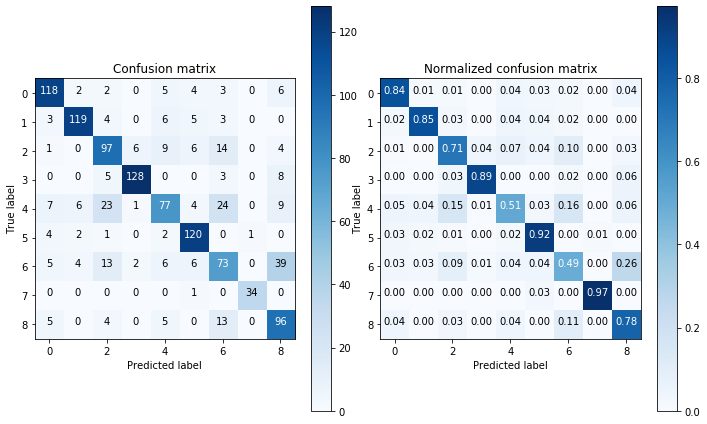

In [48]:
import itertools
import sklearn.metrics
from matplotlib import gridspec

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(10, 6))
grid_spec = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Plot non-normalized confusion matrix
plt.subplot(grid_spec[0])
plot_confusion_matrix(confusion_matrix,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(grid_spec[1])
plot_confusion_matrix(confusion_matrix, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

* The confusion matrix shows that the classifiers manages the problem relatively well, but has a low score for class Nr 6 (Scratch) and Nr 4 (Loc)

# 4. A Deep Learning approach <a name="deep"></a>

In [49]:
downsampled_dataframe

,failureType,failureNum,waferMapResized
50263,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,..."
27341,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
127669,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,..."
125300,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
89192,[[Center]],0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,..."
...,...,...,...
153122,[[none]],8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
133242,[[none]],8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
119222,[[none]],8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,..."
144000,[[none]],8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [50]:
downsampled_dataframe.count()

failureType        4589
failureNum         4589
waferMapResized    4589
dtype: int64

In [51]:
# Features
X = downsampled_dataframe.waferMapResized

In [52]:
x2_reshaped = []
for item in X:
    x2_reshaped.append(item)

X_reshaped = np.array(x2_reshaped)

In [53]:
X_reshaped.shape

(4589, 32, 32)

In [54]:
X_reshaped = np.expand_dims(X_reshaped, axis=0)
X_reshaped = np.transpose(X_reshaped, (1, 2, 3, 0))
X_reshaped.shape

(4589, 32, 32, 1)

In [55]:
# Label
y = downsampled_dataframe.failureNum

# Splitting the features in train / test
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, random_state=0)
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

Training target statistics: Counter({8: 432, 5: 425, 2: 418, 1: 415, 0: 415, 3: 411, 6: 407, 4: 404, 7: 114})
Testing target statistics: Counter({4: 151, 6: 148, 3: 144, 0: 140, 1: 140, 2: 137, 5: 130, 8: 123, 7: 35})


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## 4.1 Simple CNN <a name="cnn"></a>

In [57]:
model = Sequential()
img_shape = (32, 32, 1)

# First set of layers

# Convolutional layer
model.add(Conv2D(filters=32, kernel_size=(6, 6),
                 input_shape=img_shape, activation='relu',))
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Second set of layers

# Convolutional layer
model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu',))
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Flatten images before fully connected dense layer
model.add(Flatten())

# Dense layer
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# Classifier layer, 9 classes
model.add(Dense(9, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              #loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
____

In [58]:
early_stop = EarlyStopping(monitor='val_acc', patience=20)

In [59]:
batch_size = 32
epochs = 50

history = None  # For recording the history of trainning process.
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    shuffle=True)

Train on 3441 samples, validate on 1148 samples
Epoch 1/50
3441/3441 [==============================] - 10s 3ms/sample - loss: 1.6359 - acc: 0.3795 - val_loss: 1.1659 - val_acc: 0.6054
Epoch 2/50
3441/3441 [==============================] - 2s 641us/sample - loss: 1.0836 - acc: 0.5990 - val_loss: 1.1093 - val_acc: 0.6150
Epoch 3/50
3441/3441 [==============================] - 2s 653us/sample - loss: 0.9434 - acc: 0.6376 - val_loss: 0.8653 - val_acc: 0.6803
Epoch 4/50
3441/3441 [==============================] - 2s 656us/sample - loss: 0.8309 - acc: 0.6783 - val_loss: 0.7838 - val_acc: 0.7030
Epoch 5/50
3441/3441 [==============================] - 2s 650us/sample - loss: 0.7836 - acc: 0.7010 - val_loss: 0.6936 - val_acc: 0.7413
Epoch 6/50
3441/3441 [==============================] - 2s 641us/sample - loss: 0.7533 - acc: 0.7068 - val_loss: 0.7008 - val_acc: 0.7517
Epoch 7/50
3441/3441 [==============================] - 3s 757us/sample - loss: 0.7038 - acc: 0.7297 - val_loss: 0.6692 - val

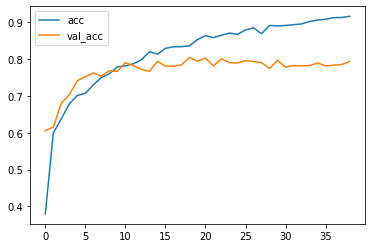

In [60]:
losses = pd.DataFrame(model.history.history)
losses[['acc','val_acc']].plot()

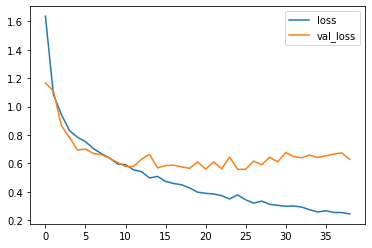

In [61]:
losses[['loss','val_loss']].plot()

In [62]:
Y_pred = model.predict(X_test)

In [63]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred

array([6, 3, 0, ..., 1, 2, 5])

In [64]:
Y_true = y_test.values
Y_true

array([6, 3, 0, ..., 1, 2, 5], dtype=object)

In [65]:
Y_true = list(Y_true)

Text(0.5, 103.73999999999997, 'Predicted')

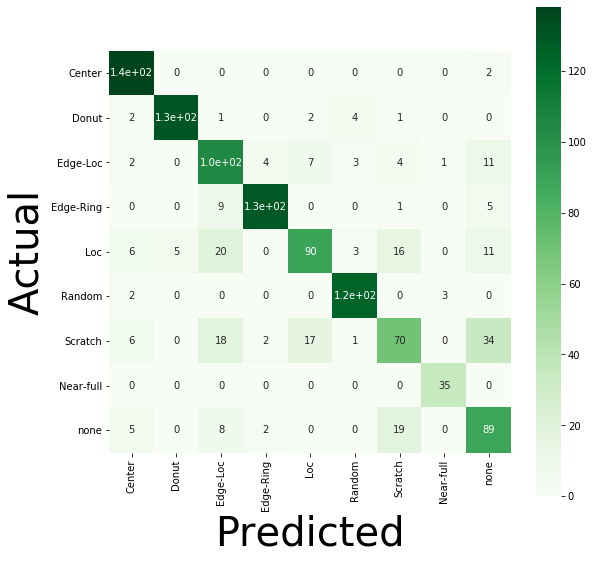

In [66]:
# from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = sklearn.metrics.confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(9, 9))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True,
                 square=True, xticklabels=labels, yticklabels=labels)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## 4.2 DenseNet + Data augmentation <a name="densenet"></a>

In [70]:
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

EPOCHS = 50
SIZE = 32
N_ch = 1
BATCH_SIZE = 32

def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = densenet(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(9, activation='softmax', name='root')(x)

    # model
    model = Model(input, output)

    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999,
                     epsilon=0.1, decay=0.0)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [72]:
model = build_densenet()
annealer = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             vertical_flip=True)  # Randomly flip inputs vertically
datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                           steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                           epochs=EPOCHS,
                           verbose=2,
                           callbacks=[annealer, checkpoint],
                           validation_data=(X_test, y_test))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 3)         30        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2624

 - 33s - loss: 0.4780 - accuracy: 0.8291 - val_loss: 0.4197 - val_accuracy: 0.8624

Epoch 00042: val_loss did not improve from 0.41448
Epoch 43/50
 - 33s - loss: 0.4942 - accuracy: 0.8315 - val_loss: 0.4352 - val_accuracy: 0.8493

Epoch 00043: val_loss did not improve from 0.41448
Epoch 44/50
 - 33s - loss: 0.4777 - accuracy: 0.8316 - val_loss: 0.4353 - val_accuracy: 0.8528

Epoch 00044: val_loss did not improve from 0.41448
Epoch 45/50
 - 33s - loss: 0.4899 - accuracy: 0.8258 - val_loss: 0.4180 - val_accuracy: 0.8606

Epoch 00045: val_loss did not improve from 0.41448
Epoch 46/50
 - 33s - loss: 0.4648 - accuracy: 0.8447 - val_loss: 0.4093 - val_accuracy: 0.8632

Epoch 00046: val_loss improved from 0.41448 to 0.40932, saving model to model.h5
Epoch 47/50
 - 33s - loss: 0.4922 - accuracy: 0.8302 - val_loss: 0.3943 - val_accuracy: 0.8641

Epoch 00047: val_loss improved from 0.40932 to 0.39429, saving model to model.h5
Epoch 48/50
 - 33s - loss: 0.4736 - accuracy: 0.8405 - val_loss: 0.392

In [73]:
# To load a trained model --> model = load_model('model.h5')
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

1148/1148 [==============================] - 4s 3ms/step
Final Loss: 0.3991652083313839, Final Accuracy: 0.8588849902153015


Text(0.5, 145.31999999999996, 'Predicted')

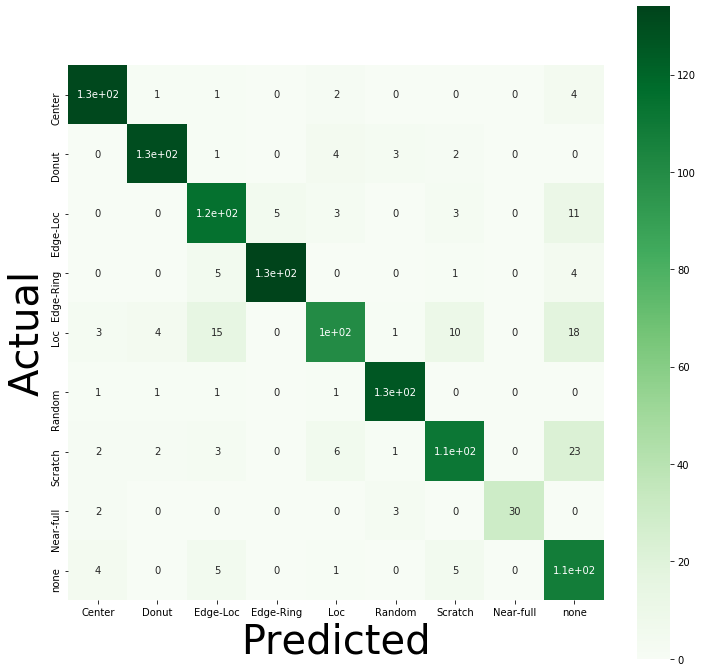

In [74]:
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)

Y_true = y_test.values
Y_true = list(Y_true)
cm = sklearn.metrics.confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True,
                 square=True, xticklabels=labels, yticklabels=labels)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

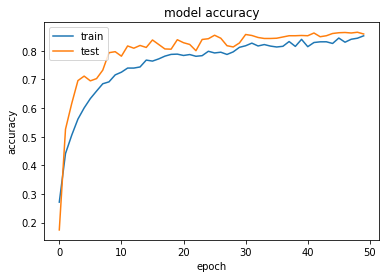

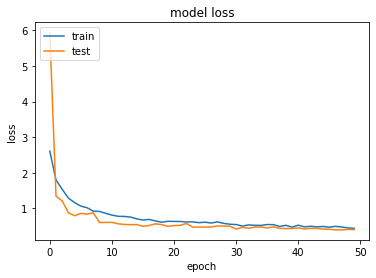

In [75]:
# accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So, reaching an accuracy of 0.858, the use of DenseNet121 with data augmentation, improved the accuracy from previous results.

## 5 References <a name="ref"></a>

1 - https://www.rsipvision.com/wafer-macro-defects-detection-classification/ <br>
2 - https://en.wikipedia.org/wiki/Substrate_mapping <br>
3 - http://mirlab.org/dataSet/public/ <br>
4 - http://kaggle.com/shawon10/wafer-map-defect-classification-by-densenet121/data <br>
5 - http://cs230.stanford.edu/projects_fall_2019/reports/26261124.pdf